Title: Are the Warriors better without Kevin Durant? 
Date: 2019-06-10 12:00
Tags: python
Slug: ab_kd

In the media, there have been debates about whether or not the Golden State Warriors (GSW) are better without Kevin Durant (KD). From the eye-test, it's laughable to even suggest this, as he's one of the top 3 players in the league (Lebron, KD, Kawhi). Nonetheless, people argue that ball movement is better without him, and therefore make the GSW more lethal.

But, just because the Warriors won a title without KD, does not mean they don't need him more than ever. At the time of writing, the Toronto Raptors lead 3-1 in the Finals! #WeTheNorth 🦖🍁

Using Bayesian estimation, we can test this hypothesis, by comparing two treatment groups, games played with KD and without KD.

Bayesian statistics are an excellent tool to reach for when sample sizes are small, as we can introduce explicit assumptions into the model, when there aren't thousands of observations. 

---

# Primer on Bayesian Statistics

<img src="images/dist.png" class="img-responsive">

$$P\left(model\;|\;data\right) = \frac{P\left(data\;|\;model\right)}{P(data)}\; P\left(model\right)$$

---


$$ \text{prior} = P\left(model\right) $$
> The **prior** is our belief in the model given no additional information. In our example, this is the mean win % with KD playing.


$$ \text{likelihood} = P\left(data\;|\;model\right) $$
> The **likelihood** is the probability of the data we observed occurring given the model.

$$ \text{marginal probability of data} = P(data) $$
> The **marginal probability** of the data is the probability that our data are observed regardless of what model we choose or believe in. 

$$ \text{posterior} = P\left(model\;|\;data\right) $$
> The **posterior** is our _updated_ belief in the model given the new data we have observed. Bayesian statistics are all about updating a prior belief we have about the world with new data, so we're transforming our _prior_ belief into this new _posterior_ belief about the world. <br><br> In this example, this is the GSW mean winning % with KD playing, given the game logs from the past three seasons.


Note, a Bayesian approach is different from a Frequentist's. Rather than only testing whether two groups are different, we instead pursue an estimate of _how_ different they are, from the posterior distribution.

## Objective
To calculate the distribution of the posterior probability of GSW mean winning % with KD and without KD.

Moreover, we can calculate the _delta_ between both probabilities to determine if the mean is statistically different from zero (i.e. no difference with or without him).

---
# Observed Data

In [18]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import pymc3 as pm
from IPython.display import HTML
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')
from IPython.core.pylabtools import figsize
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

As the competition is much higher in the playoffs, let's analyze Playoff vs. Regular Season data separately. We can run one test on the regular season, and one test for the playoffs.  

Data is from [Basketball Reference](https://www.basketball-reference.com/).

---
# Regular Season

<table class="table">
 <thead class="table-responsive table-bordered">
    <tr>
      <th scope="col">Regular Season</th>
      <th scope="col">With Kevin Durant</th>
      <th scope="col">No Kevin Durant</th>
      <th scope="col">Notes</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>2019</td>
      <td>0.69 <br> {'W': 54, 'L': 24} </td>
      <td>0.75 <br> {'W': 3, 'L': 1} </td>
      <td>Record is better when KD is out, but small sample size.</td>
    </tr>
    <tr>
      <td>2018</td>
      <td>0.72 <br> {'W': 49, 'L': 19} </td>
      <td>0.64 <br> {'W': 9, 'L': 5} </td>
      <td>Record is better when KD plays</td>
    </tr>
    <tr>
      <td>2017</td>
      <td>0.82 <br> {'W': 51, 'L': 11} </td>
      <td>0.80 <br> {'W': 16, 'L': 4} </td>
      <td>Record is better when KD plays</td>
    </tr>
    <tr>
      <td>Total (3 seasons)</td>
      <td>0.740 <br> {'W': 154, 'L': 54} </td>
      <td>0.737 <br> {'W': 28, 'L': 10} </td>
      <td>Record is better when KD plays</td>
    </tr>
  </tbody>
</table>

Over the last three seasons with the Warriors, KD has missed 38 games regular season games, and played in 208.

In [19]:
def occurrences(year, kd=True):
    '''occurences(2019, kd=True)
    By default, kd=True means with KD healthy'''
    # clean data
    # regular season
    data = pd.read_csv(f'./data/{year}.txt', sep=',')
    new_columns = ['Rk', 'G', 'Date', 'Age', 'Tm', 'Away', 'Opp', 'Result', 'GS',
       'MP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', 'FT', 'FTA', 'FT%', 'ORB',
       'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'GmSc', '+/-']
    data.columns=new_columns
    # replace did not dress with inactive
    data.GS = np.where(data.GS == 'Did Not Dress','Inactive',data.GS)
    if kd == False:
        game_logs = list(data[data.GS=='Inactive'].Result)
    else:
        game_logs = list(data[data.GS!='Inactive'].Result)
    results = [game.split(' ')[0] for game in game_logs]
    occurrences = [1 if result == 'W' else 0 for result in results]
    return occurrences

In [20]:
regular_season_with_kd = occurrences(2019, kd=True)+occurrences(2018, kd=True)+occurrences(2017, kd=True)
regular_season_no_kd = occurrences(2019, kd=False)+occurrences(2018, kd=False)+occurrences(2017, kd=False)
print(f'Observed win % when Kevin Durant plays: {round(np.mean(regular_season_with_kd),4)}')
print(f'Observed win % when Kevin Durant does not play: {round(np.mean(regular_season_no_kd),4)}')

Observed win % when Kevin Durant plays: 0.7404
Observed win % when Kevin Durant does not play: 0.7368


* Note, we do not know the true win %, only the observed win %. We infer the true quantity from the observed data.

* Notice the unequal sample sizes (208 vs. 38), but this is not problem in Bayesian analysis. We will see the uncertainty of the smaller sample size captured in the posterior distribution. 

---
## Bayesian Tests with MCMC

* Markov Chain Monte Carlo (MCMC) is a method to find the posterior distribution of our parameter of interest.
> This type of algorithm generates Monte Carlo simulations in a way that relies on the Markov property, then accepts these simulations at a certain rate to get the posterior distribution.

* We will use [PyMC3](https://docs.pymc.io/), a probabilistic library for Python to generate MC simulations.

* Before seeing any of the data, my prior is that GSW will win between 50% - 90% of their games, because they are an above average basketball team, and no team has ever won more than 72 games.

In [21]:
# Instantiate
observations_A = regular_season_with_kd
observations_B = regular_season_no_kd

with pm.Model() as model:
    # Assume Uniform priors for p_A and p_B    
    p_A = pm.Uniform("p_A", 0.5, .9)
    p_B = pm.Uniform("p_B", 0.5, .9)
    
    # Define the deterministic delta function. This is our unknown of interest.
    # Delta is deterministic, no uncertainty beyond p_A and p_B
    delta = pm.Deterministic("delta", p_A - p_B)
    
    # We have two observation datasets: A, B
    # Posterior distribution is Bernoulli
    obs_A = pm.Bernoulli("obs_A", p_A, observed=observations_A)
    obs_B = pm.Bernoulli("obs_B", p_B, observed=observations_B)
    
    # Draw samples from the posterior distribution
    trace = pm.sample(20000)
    burned_trace=trace[1000:]

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [p_B, p_A]
Sampling 2 chains: 100%|██████████| 41000/41000 [00:19<00:00, 2078.93draws/s]


* Using PyMC3, we generated a trace, or chain of values from the posterior distribution 
* Generated 20,000 samples from the posterior distribution (20,000 samples / chain / core)

Because this algorithm needs to converge, we set a number of tuning steps (1,000) to occur first and where the algorithm should "start exploring." It's good to see the Markov Chains overlap, which suggests convergence.

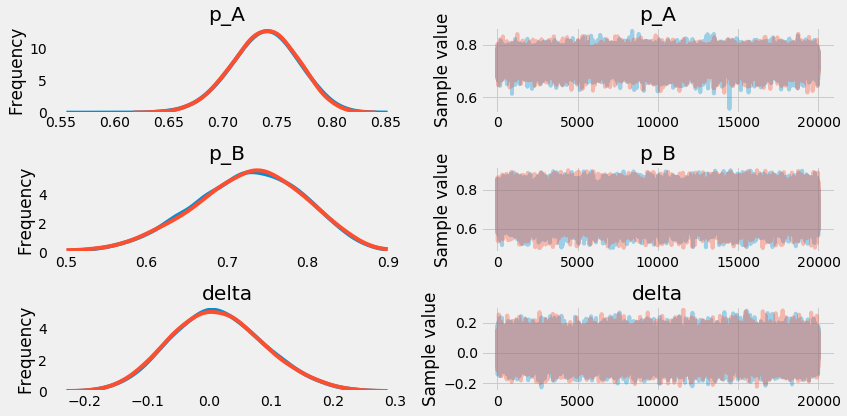

In [22]:
pm.traceplot(trace);
# plt.savefig('trace.svg');

In [23]:
df = pm.summary(burned_trace).round(2)[['mean', 'sd', 'hpd_2.5', 'hpd_97.5']]
HTML(df.to_html(classes="table table-responsive table-striped table-bordered"))

,mean,sd,hpd_2.5,hpd_97.5
p_A,0.74,0.03,0.68,0.80
p_B,0.73,0.07,0.59,0.86
delta,0.01,0.08,-0.13,0.16


* Unlike with confidence intervals (frequentist), there is a measure of probability with the credible interval.
* There is a 95% probability that the true win rate with KD is in the interval (0.68, 0.79).
* There is a 95% probability that the true win rate with no KD is in the interval (0.59, 0.85).

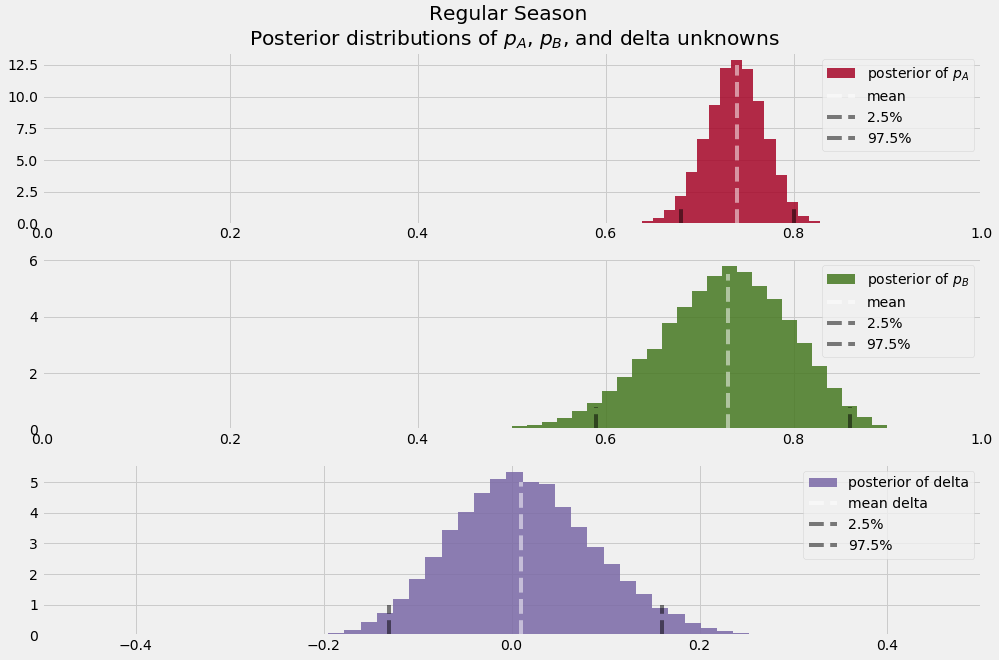

In [31]:
p_A_samples = burned_trace["p_A"]
p_B_samples = burned_trace["p_B"]
delta_samples = burned_trace["delta"]

figsize(15, 10)
ax = plt.subplot(311)

plt.xlim(0, 1)
plt.hist(p_A_samples, histtype='stepfilled', bins=25, alpha=0.85,
         label="posterior of $p_A$", color="#A60628", density=True)
plt.vlines(df.iloc[0]["mean"], 0, 12.5, color="white", alpha=0.5,linestyle="--",
           label=f'mean')
plt.vlines(df.iloc[0]["hpd_2.5"], 0, 1.3, color="black", alpha=0.5,linestyle="--",
           label='2.5%')
plt.vlines(df.iloc[0]["hpd_97.5"], 0, 1.3, color="black", alpha=0.5,linestyle="--",
           label='97.5%')
plt.legend(loc="upper right")
plt.title("Regular Season \n Posterior distributions of $p_A$, $p_B$, and delta unknowns")

ax = plt.subplot(312)

plt.xlim(0, 1)
plt.hist(p_B_samples, histtype='stepfilled', bins=25, alpha=0.85,
         label="posterior of $p_B$", color="#467821", density=True)
plt.vlines(df.iloc[1]["mean"], 0, 5.5, color="white", alpha=0.5,linestyle="--",
           label=f'mean')
plt.vlines(df.iloc[1]["hpd_2.5"], 0, .8, color="black", alpha=0.5,linestyle="--",
           label='2.5%')
plt.vlines(df.iloc[1]["hpd_97.5"], 0, .8, color="black", alpha=0.5,linestyle="--",
           label='97.5%')
plt.legend(loc="upper right")


ax = plt.subplot(313)
plt.xlim(-0.5, 0.5)
plt.hist(delta_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of delta", color="#7A68A6", density=True)

plt.vlines(df.iloc[2]["mean"], 0, 5, color="white", alpha=0.5,linestyle="--",
           label=f'mean delta')
plt.vlines(df.iloc[2]["hpd_2.5"], 0, 1, color="black", alpha=0.5,linestyle="--",
           label='2.5%')
plt.vlines(df.iloc[2]["hpd_97.5"], 0, 1, color="black", alpha=0.5,linestyle="--",
           label='97.5%')

plt.legend(loc="upper right");
# plt.savefig('reg_season.svg');

Note, the 2.5% and 97.5% markers indicate the quantiles for the credible interval, similar to the confidence interval in frequentist statistics.

---
## Results

* In the third graph, the posterior win rate is 1.2% higher when KD plays in the regular season.

* Observe that because have less data for when KD is out, our posterior distribution of  𝑝𝐵 is wider, implying we are less certain about the true value of 𝑝𝐵 than we are of 𝑝𝐴. The 95% credible interval is much wider for $p_B$, as there is a smaller sample size, for when KD did not play. We are less certain that the GSW wins 73% of the time without KD.

* The difference in sample sizes ($N_B$ < $N_A$) naturally fits into Bayesian analysis, whereas you need the same populations for frequentist approach!

In [25]:
# Count the number of samples less than 0, i.e. the area under the curve
print("Probability that GSW is worse with Kevin Durant in the regular season: %.2f" % \
    np.mean(delta_samples < 0))

print("Probability that GSW is better with Kevin Durant in the regular season: %.2f" % \
    np.mean(delta_samples > 0))

Probability that GSW is worse with Kevin Durant in the regular season: 0.45
Probability that GSW is better with Kevin Durant in the regular season: 0.55


The probabilities are pretty close, so we can chalk this up to the Warriors having a experienced supporting cast. 

There is significant overlap between the distribution pf posterior pA and posterior of pB, so one is not better than the other with high probability. The majority of the distribution of delta is around 0, so there is no statistically difference between the groups in the regular season.

Ideally, we should perform more trials when KD is injured (as each data point for scenario B contributes more inferential power than each additional point for scenario A). One could do a similar analysis for when he played on the Oklahoma City Thunder.

---
# Playoffs
## Do superstars shine when the stakes are highest?

<table class="table">
 <thead class="table-responsive table-bordered">
    <tr>
      <th scope="col">Playoffs</th>
      <th scope="col">With Kevin Durant</th>
      <th scope="col">No Kevin Durant</th>
      <th scope="col">Notes</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>2019</td>
      <td>0.64 <br> {'W': 7, 'L': 4} </td>
      <td>0.66 <br> {'W': 6, 'L': 3} </td>
      <td>Record is marginally better when KD is out, but small sample size. Skewed by Portland series, which GSW won 4-0 with KD injured.</td>
    </tr>
    <tr>
      <td>2018</td>
      <td>0.76 <br> {'W': 16, 'L': 5} </td>
      <td>n/a <br> {'W': 0, 'L': 0} </td>
      <td>KD did not miss any games. Won Championship.</td>
    </tr>
    <tr>
      <td>2017</td>
      <td>0.82 <br> {'W': 14, 'L': 1} </td>
      <td>1 <br> {'W': 2, 'L': 0}. Small sample size. </td>
      <td>Won championship.</td>
    </tr>
      <td>Total (3 seasons)</td>
      <td>0.79 <br> {'W': 37, 'L': 10} </td>
      <td>0.73 <br> {'W': 8, 'L': 3} </td>
      <td>Record is better when KD plays</td>
  </tbody>
</table>

In [26]:
playoffs_with_kd = occurrences('2019_playoffs', kd=True)+occurrences('2018_playoffs', kd=True)+occurrences('2017_playoffs', kd=True)
playoffs_no_kd = occurrences('2019_playoffs', kd=False)+occurrences('2018_playoffs', kd=False)+occurrences('2017_playoffs', kd=False)
print(f'Observed win % when Kevin Durant plays: {round(np.mean(playoffs_with_kd),2)}')
print(f'Observed win % when Kevin Durant does not play: {round(np.mean(playoffs_no_kd),2)}')

Observed win % when Kevin Durant plays: 0.79
Observed win % when Kevin Durant does not play: 0.73


Over the last three playoff runs with the Warriors, KD has missed 11, and played in 47.

See how the difference is much more pronounced with more data across three seasons. Let's similar if the GSW has a higher win % with KD in the playoffs. 

In [27]:
playoff_obs_A = playoffs_with_kd
playoff_obs_B = playoffs_no_kd

with pm.Model() as playoff_model:
    playoff_p_A = pm.Uniform("playoff_p_A", 0, 1)
    playoff_p_B = pm.Uniform("playoff_p_B", 0, 1)
    
    playoff_delta = pm.Deterministic("playoff_delta", playoff_p_A - playoff_p_B)
    
    playoff_obs_A = pm.Bernoulli("playoff_obs_A", playoff_p_A, observed=playoff_obs_A)
    playoff_obs_B = pm.Bernoulli("playoff_obs_B", playoff_p_B, observed=playoff_obs_B)

    playoff_trace = pm.sample(20000)
    playoff_burned_trace=playoff_trace[1000:]

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [playoff_p_B, playoff_p_A]
Sampling 2 chains: 100%|██████████| 41000/41000 [00:20<00:00, 2000.19draws/s]


In [28]:
df2 = pm.summary(playoff_burned_trace).round(2)[['mean', 'sd', 'hpd_2.5', 'hpd_97.5']]
HTML(df2.to_html(classes="table table-responsive table-striped table-bordered"))

,mean,sd,hpd_2.5,hpd_97.5
playoff_p_A,0.78,0.06,0.66,0.88
playoff_p_B,0.69,0.12,0.46,0.92
playoff_delta,0.08,0.14,-0.16,0.36


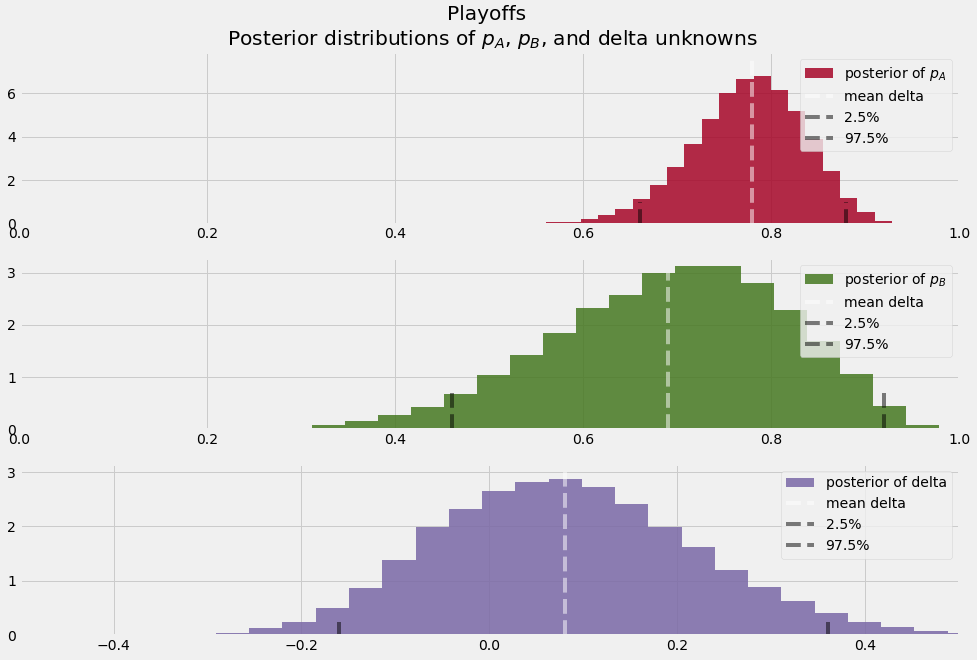

In [29]:
playoff_p_A_samples = playoff_burned_trace['playoff_p_A']
playoff_p_B_samples = playoff_burned_trace["playoff_p_B"]
playoff_delta_samples = playoff_burned_trace["playoff_delta"]

figsize(15, 10)

#histogram of posteriors

ax = plt.subplot(311)

plt.xlim(0, 1)
plt.hist(playoff_p_A_samples, histtype='stepfilled', bins=25, alpha=0.85,
         label="posterior of $p_A$", color="#A60628", density=True)
plt.vlines(df2.iloc[0]["mean"], 0, 7.5, color="white", alpha=0.5,linestyle="--",
           label=f'mean delta')
plt.vlines(df2.iloc[0]["hpd_2.5"], 0, 1, color="black", alpha=0.5,linestyle="--",
           label='2.5%') 
plt.vlines(df2.iloc[0]["hpd_97.5"], 0, 1, color="black", alpha=0.5,linestyle="--",
           label='97.5%')
plt.legend(loc="upper right")
plt.title("Playoffs \n Posterior distributions of $p_A$, $p_B$, and delta unknowns")

ax = plt.subplot(312)

plt.xlim(0, 1)
plt.hist(playoff_p_B_samples, histtype='stepfilled', bins=25, alpha=0.85,
         label="posterior of $p_B$", color="#467821", density=True)
plt.vlines(df2.iloc[1]["mean"], 0, 3, color="white", alpha=0.5,linestyle="--",
           label=f'mean delta')
plt.vlines(df2.iloc[1]["hpd_2.5"], 0, .8, color="black", alpha=0.5,linestyle="--",
           label='2.5%')
plt.vlines(df2.iloc[1]["hpd_97.5"], 0, .8, color="black", alpha=0.5,linestyle="--",
           label='97.5%')
plt.legend(loc="upper right")


ax = plt.subplot(313)
plt.xlim(-0.5, 0.5)
plt.hist(playoff_delta_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of delta", color="#7A68A6", density=True)

plt.vlines(df2.iloc[2]["mean"], 0, 3, color="white", alpha=0.5,linestyle="--",
           label=f'mean delta')
plt.vlines(df2.iloc[2]["hpd_2.5"], 0, 0.25, color="black", alpha=0.5,linestyle="--",
           label='2.5%')
plt.vlines(df2.iloc[2]["hpd_97.5"], 0, 0.25, color="black", alpha=0.5,linestyle="--",
           label='97.5%')

plt.legend(loc="upper right");
# plt.savefig('playoffs.svg');

In [30]:
# Count the number of samples less than 0, i.e. the area under the curve
print("Probability that GSW is worse with Kevin Durant in the playoffs: %.2f" % \
    np.mean(playoff_delta_samples < 0))

print("Probability that GSW is better with Kevin Durant in the playoffs: %.2f" % \
    np.mean(playoff_delta_samples > 0))

Probability that GSW is worse with Kevin Durant in the playoffs: 0.28
Probability that GSW is better with Kevin Durant in the playoffs: 0.72


---
## Are the Warriors better without Kevin Durant? No.

By combining results from the past three seasons, we obtain a larger test group, which allows us to observe a real change vs. looking at the pure stats for a single year.

We can see that while delta=0 (i.e. no effect when KD plays) is in the credible interval at 95%, the majority of the distribution is above delta=0, implying the treatment group with KD is likely better than the group without KD. In fact, the probability that GSW is better with Kevin Durant in the playoffs is 71%, a significant improvement than 55% in the regular season! 

Superstars make a significant difference. The regular season is where you make your name, but the postseason is where you make your fame. The delta is 8% higher with KD. That's the advantage you gain with a player of his caliber, as he can hit clutch shots when it matters most.

As a basketball fan, I hope to see Kevin Durant healthy and back in action soon.

# References
* https://multithreaded.stitchfix.com/blog/2015/05/26/significant-sample/
* https://multithreaded.stitchfix.com/blog/2015/02/12/may-bayes-theorem-be-with-you/